In [1]:
import pandas as pd 
import janitor

def get_data():
    URL_CSV="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
    df = pd.read_csv(URL_CSV)
    df['Country/Region'] = df['Country/Region'].replace({'US':'United States of America'})
    return df
df = get_data()


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1,2020-01-23,-4.364627e+03,0.000000e+00,1.012915e+05,-4.364627e+03,-4.364627e+03,8845.983531,8845.983531,8845.983531,8845.983531,8845.983531,8845.983531,0.0,0.0,0.0,4.481356e+03
2,2020-01-24,-1.748403e+03,0.000000e+00,1.008613e+05,-1.748403e+03,-1.748403e+03,2651.973136,2651.973136,2651.973136,2651.973136,2651.973136,2651.973136,0.0,0.0,0.0,9.035698e+02
3,2020-01-25,8.678208e+02,0.000000e+00,1.059749e+05,8.678208e+02,8.678208e+02,4539.371965,4539.371965,4539.371965,4539.371965,4539.371965,4539.371965,0.0,0.0,0.0,5.407193e+03
4,2020-01-26,3.484045e+03,0.000000e+00,9.736039e+04,3.484045e+03,3.484045e+03,83.853398,83.853398,83.853398,83.853398,83.853398,83.853398,0.0,0.0,0.0,3.567898e+03
6,2020-01-28,8.716493e+03,0.000000e+00,1.058040e+05,8.716493e+03,8.716493e+03,-6815.564371,-6815.564371,-6815.564371,-6815.564371,-6815.564371,-6815.564371,0.0,0.0,0.0,1.900929e+03
7,2020-01-29,1.133271e+04,0.000000e+00,1.060146e+05,1.133271e+04,1.133271e+04,-1107.473970,-1107.473970,-1107.473970,-1107.473970,-1107.473970,-1107.473970,0.0,0.0,0.0,1.022524e+04
8,2020-01-30,1.394893e+04,0.000000e+00,1.242241e+05,1.394893e+04,1.394893e+04,8845.983531,8845.983531,8845.983531,8845.983531,8845.983531,8845.983531,0.0,0.0,0.0,2.279492e+04
9,2020-01-31,1.656516e+04,0.000000e+00,1.199634e+05,1.656516e+04,1.656516e+04,2651.973136,2651.973136,2651.973136,2651.973136,2651.973136,2651.973136,0.0,0.0,0.0,1.921713e+04
10,2020-02-01,1.918138e+04,0.000000e+00,1.105669e+05,1.918138e+04,1.918138e+04,4539.371965,4539.371965,4539.371965,4539.371965,4539.371965,4539.371965,0.0,0.0,0.0,2.372075e+04
11,2020-02-02,2.179760e+04,0.000000e+00,1.173969e+05,2.179760e+04,2.179760e+04,83.853398,83.853398,83.853398,83.853398,83.853398,83.853398,0.0,0.0,0.0,2.188145e+04


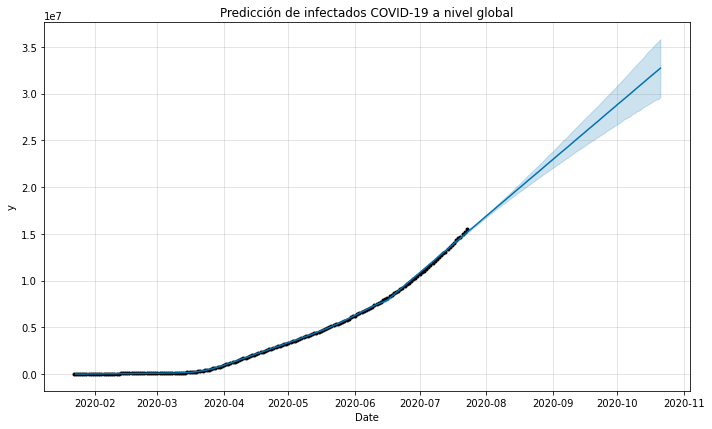

In [2]:
import janitor
import pandas as pd
import pandas_flavor as pf
import fbprophet
from matplotlib import pyplot as plt    
from IPython.display import display, HTML



LISTA_COLUMNAS_A_BORRAR = ['Province/State', 'Country/Region', 'Lat', 'Long']



df = get_data()
df = df.remove_columns(LISTA_COLUMNAS_A_BORRAR)
df
df = pd.DataFrame( df.sum())
df.columns=['y']
df.index = pd.to_datetime(df.index)  
df['ds'] = df.index
df = df.reset_index()


df = df.remove_columns(['index'])


df_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)
df_prophet.fit(df)

df_forecast = df_prophet.make_future_dataframe(periods=90, freq='D')
# Make predictions
df_forecast = df_prophet.predict(df_forecast)
df_forecast

df_forecast = df_forecast[df_forecast["yhat"] >= 0]
df_forecast.loc[df_forecast.yhat_lower < 0, 'yhat_lower'] = 0


df_prophet.plot(df_forecast, xlabel = 'Date' )
plt.title('Predicción de infectados COVID-19 a nivel global'   )

display(HTML(pd.DataFrame(df_forecast).to_html()))


In [3]:
df = get_data()


In [4]:

import janitor
import datetime
import numpy as np

def pipeline_populations():
    """ Cogemos un dataframe de poblaciones"""

    URL="https://population.un.org/wpp/Download/Files/1_Indicators%20(Standard)/CSV_FILES/WPP2019_TotalPopulationBySex.csv"
    THIS_YEAR = datetime.datetime.now().year

    return (
        pd.read_csv(URL)
        .filter_on( f""" Time  ==  {THIS_YEAR} & Variant == "Medium" """ ) 
        .select_columns(['Location','PopTotal'])
        .join_apply(lambda x: x['PopTotal'] * 1000 , new_column_name="PopMillions" )
        .remove_columns(['PopTotal'])
        .rename_column('PopMillions' , 'PopTotal')
        .transform_column('PopTotal',np.int64)
        .rename_column('Location' , 'Country/Region')
    )


populations = pipeline_populations()
populations

,Country/Region,PopTotal
70,Afghanistan,38928341
954,Africa,1340598113
1838,African Group,1338826591
1989,African Union,1339423920
2140,African Union: Central Africa,158619638
...,...,...
277315,World,7794798728
278199,World Bank Regional Groups (developing only),6528762227
278350,Yemen,29825967
279234,Zambia,18383956


In [5]:
df = get_data()
df_country = pd.DataFrame()
df_country['Country/Region'] = df['Country/Region']
df_country['infected last_day'] = df.iloc[:,-1] - df.iloc[:,-2]
df_country.set_index('Country/Region')
df_country



,Country/Region,infected last_day
0,Afghanistan,201
1,Albania,108
2,Algeria,612
3,Andorra,0
4,Angola,39
...,...,...
261,Sao Tome and Principe,2
262,Yemen,14
263,Comoros,3
264,Tajikistan,45


In [6]:

df_country_enrich = pd.merge(df_country, populations, on="Country/Region")
df_country_enrich['Infected/Million'] =  1000000 * df_country_enrich['infected last_day'] / df_country_enrich['PopTotal'] 
df_country = df_country_enrich


In [7]:

df_country.sort_values(by='infected last_day', ascending=False).head(10)


,Country/Region,infected last_day,PopTotal,Infected/Million
222,United States of America,68663,331002647,207.439429
27,Brazil,59961,212559409,282.090547
129,India,49310,1380004385,35.731771
195,South Africa,13104,59308690,220.945700
154,Mexico,8438,128932753,65.444969
83,Colombia,7945,50882884,156.142879
6,Argentina,6127,45195777,135.565763
177,Peru,4546,32971845,137.875208
138,Kazakhstan,3333,18776707,177.507164
20,Bangladesh,2856,164689383,17.341737


In [8]:
#df_country['Country/Region'].unique()

In [9]:
#populations['Country/Region'].unique()

In [10]:
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.dates as mdates


def pintar_grafico(df, array_naciones_pintar ,title):
    df = df.T
    df = df.iloc[1:]
    new_header = df.iloc[0] #grab the first row for the header
    df = df[1:] #take the data less the header row
    df.columns = new_header #set the header row as the df header
    df = df.iloc[2:]
    df.index = pd.to_datetime(df.index)
    df = df[array_naciones_pintar]
    chart_df = df


    chart_df.plot(legend=True,figsize=(13.5,9))

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%B-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
    plt.xticks(rotation=45)

    ax = plt.gca()

    ax.set_title(title)
    ax.set_ylim(ymin=0)

    plt.show()

    df.tail(30).style.format ({ c : "{:20,.0f}" for c in df.columns }).background_gradient(cmap='Wistia', )
    return plt 



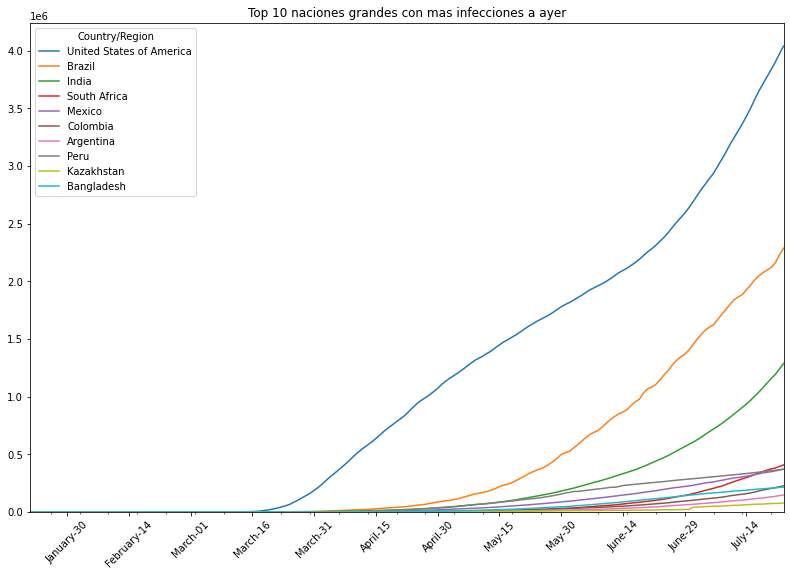

<module 'matplotlib.pyplot' from '/root/anaconda2/envs/jupyter/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [11]:
title="Top 10 naciones grandes con mas infecciones a ayer"
display(HTML(f"""<h1 id='{title}'>{title}</h1>"""))

naciones_pintar = df_country.sort_values(by='infected last_day', ascending=False).head(10)['Country/Region'].values
df_country.sort_values(by='infected last_day', ascending=False).head(10)

pintar_grafico(df,naciones_pintar,title)

In [12]:
#title="Top 10 naciones grandes con mas infeccionesa ayer en infectados/millon"
#display(HTML(f"""<h1 id='{title}'>{title}</h1>"""))

#naciones_pintar = df_country.filter_on("PopTotal > 25000000").sort_values(by='Infected/Million', ascending=False).head(10)['Country/Region'].values
#df_country.sort_values(by='infected last_day', ascending=False).head(10)

#pintar_grafico(df_country,naciones_pintar,title)